# Getting Started with RL4UC

This notebook will briefly describe how to use RL4UC. It will cover the following elements:

- Making an environment
- Interacting with the environment
- Training and testing an agent

## Making an Environment

Environments are specified with just a handful of arguments. The key ones are: 

- `num_gen`: number of controllable generators (must be at least 5)
- `dispatch_freq_mins`: length of settlement periods/frequency of decision-making (every 30 minutes by default)
- `voll`: the 'value of lost load', determining the magnitude of the penalty for failing to meet demand
- `arma_demand` and `arma_wind`: a dictionary specifying the details of the auto-regressive moving average processes determining the forecast errors for demand and wind
- `usd_per_kgco2`: the cost in USD of emitting a kilogram of CO2

You can manually create an environment with your specifications using `make_env()`, or you can create an environment from a json file using `make_env_from_json()`. The json which must be located in `data/envs`. There are already a few datasets in there for systems ranging from 5 to 30 generators. 

First we will create an environment manually. All the variables have default values, so we will just specify a few here:

In [1]:
from rl4uc.environment import make_env
import numpy as np

env = make_env(num_gen=10, dispatch_freq_mins=5)

The generator specifications are all derived from a single dataset, widely used in the UC literature, from: Kazarlis, S.A., Bakirtzis, A.G. and Petridis, V., 1996. A genetic algorithm solution to the unit commitment problem. IEEE transactions on power systems, 11(1), pp.83-92.

For 10 generators, the paper specifies quadratic fuel cost curves, cold and hot start costs (RL4UC currently considers hot starts), minimum up/down times and minimum and maximum operating outputs. 

Here is the data:

In [2]:
env.gen_info

,min_output,max_output,status,a,b,c,t_min_down,t_min_up,t_max_up,hot_cost,cold_cost,cold_hrs,min_fuel_cost,max_cost_per_mwh
0,150,455,96,0.00048,16.19,1000,96,96,1000000,4500,9000,1000000,18.606202,22.928667
1,150,455,96,0.00031,17.26,970,96,96,1000000,5000,10000,1000000,19.532918,23.773167
2,20,130,-60,0.00200,16.60,700,60,60,1000000,550,1100,1000000,22.244615,51.640000
3,20,130,-60,0.00211,16.50,680,60,60,1000000,560,1120,1000000,22.005069,50.542200
4,25,162,-72,0.00398,19.70,450,72,72,1000000,900,1800,1000000,23.122538,37.799500
5,20,80,-36,0.00712,22.26,370,36,36,1000000,170,340,1000000,27.454600,40.902400
6,25,85,-36,0.00079,27.74,480,36,36,1000000,260,520,1000000,33.454209,46.959750
7,10,55,-12,0.00413,25.92,660,12,12,1000000,30,60,1000000,38.147150,91.961300
8,10,55,-12,0.00222,27.27,665,12,12,1000000,30,60,1000000,39.483009,93.792200
9,10,55,-12,0.00173,27.79,670,12,12,1000000,30,60,1000000,40.066968,94.807300


When we set `num_gen < 10`, RL4UC takes a subset of these generators by default. When using more than 10 generators, we use duplicates of these generators.

When making an environment from a json, we need to specify the environment's 'name', that is the prefix to '.json'. As mentioned, this must be in the directory `data/envs`. 

In [3]:
from rl4uc.environment import make_env_from_json

env = make_env_from_json('20gen_carbon1')

The preset environments are aimed at better defining benchmarks that people can compare performance on.

### Training and Testing Modes

Environments have two modes: train and test. Training mode is designed for when we want to sample from a **range of episodes**, specified in `env.profiles_df`. In training mode, when we 'reset' with `env.reset()` the environment samples a new episode from `env.profiles_df`. This makes it useful for training agents. In test mode, we are considering the case where `env.profiles_df` is **a single test episode**, and we want to evaluate the performance. Typically the test problem will not have been observed in training.

When making an environment in training mode (e.g. `make_env(mode='train')`), the profiles in `data/train_data_10gen.csv` are automatically scaled to the number of generators and available as episodes. These profile are based on data from the GB power system. By contrast, when using a test environment you **must** specify a test profile.

Some other differences between training and testing:

- In train mode, states are terminal if there is lost load. In testing the episode continues. 
- In train mode, resetting the environment randomly initialises the generator up/down times. In test mode they are initialised to `env.gen_info.status`

## Interacting with the environment

RL4UC **roughly** follows the OpenAI Gym API. In other words, we act on the environment by executing `env.step(action)`, which returns an observation, reward and an indicator of whether the state is terminal. (Currently the 'info' return is not implemented). We can reset the environment to begin a new episode with `env.reset()`. **An action is a binary sequence of length `env.num_gen`, where 1 indicates turning the generator on, and 2 indicates turning it off.**

For instance:

In [4]:
env = make_env_from_json('5gen') # make the environment
obs = env.reset() # reset the environment
action = np.array([1,1,1,1,0]) # turn all but the last generator on
obs, reward, done = env.step(action) # act on the environment

print("Reward: {}".format(reward))
print("Done: {}".format(done))

Reward: -7835.415966447421
Done: False


We can see the reward achieved by the action. In addition, we can see whether the environment is 'done': that is, whether it has reached a terminal state. 

**NOTE: currently (and counter-intuitively) you can still continue to act on an environment after it has reached a terminal state. When training, you should embed each episode in a while loop, that checks for if environment is done (as in the next section).**

### States

States are comprised predominantly of the following components: generator up/down times, demand forecast, wind forecast, timestep. In addition are the forecast errors, produced by the ARMA processes. **Note: while the forecast errors are returned in the observation, you may want to consider whether the agent *should* observe this in a particular problem setting. If you are training an agent to solve the day-ahead problem, it probably *shouldn't* observe them, as that won't be possible when it comes to testing!**

Let's see the observed state from the code block above:

In [5]:
obs

{'status': array([ 1, 11, 13,  7, -1]),
 'demand_forecast': array([516.42147491, 519.11935418, 522.06381382, 518.95980218,
        516.24741818, 514.40531782, 507.93620945, 503.00460218,
        498.59516509, 499.53797236, 508.21179927, 517.161216  ,
        560.240256  , 607.03250618, 652.73690182, 671.82512291,
        694.423488  , 704.37373091, 708.783168  , 710.39319273,
        709.07326255, 704.59130182, 695.98999855, 694.69907782,
        690.36216436, 685.41605236, 692.63940655, 692.37832145,
        696.94731055, 699.34059055, 701.93693673, 715.33930473,
        722.53364945, 744.16019782, 767.78839855, 787.97897891,
        789.13935709, 781.90149818, 769.86257455, 753.39970909,
        729.42339491, 700.06582691, 667.15460073, 632.32875055,
        601.86882327, 571.64097164, 547.14248727, 534.49436509]),
 'demand_errors': array([-13.95413774,   0.        ,   0.        ,   0.        ,
          0.        ]),
 'wind_forecast': array([2.90985226e+02, 2.98426773e+02, 2.5174500

The `status` component gives the up/down times in decision periods. Remember that the generators have minimum up/down time constraints, so the up/down times are a very important component of the state vector.

## Training an Agent

Now we'll look at how to train an agent. 

In this case we'll look at a simple Q-learning agent. Needless to say, this is a pretty simple solution that could be vastly improved.

**Note: this requires Pytorch to run yourself.**

In [305]:
import torch
import torch.nn as nn
import torch.optim as optim

class QAgent(nn.Module):
    def __init__(self, env):
        super(QAgent, self).__init__()
        self.num_gen = env.num_gen
        
        self.num_nodes = 32
        self.gamma = 0.99
        self.activation = torch.tanh
        
        # There are 2N output nodes, corresponding to ON/OFF for each generator
        self.n_out = 2*self.num_gen
        
        self.obs_size = self.process_observation(env.reset()).size
        
        self.in_layer = nn.Linear(self.obs_size, self.num_nodes)
        self.out_layer = nn.Linear(self.num_nodes, self.n_out) 
        
        self.optimizer = optim.Adam(self.parameters(), lr=3e-04)
        self.criterion = nn.MSELoss()
        
                
    def process_observation(self, obs):
        """
        Process an observation into a numpy array.
        
        Observations are given as dictionaries, which is not very convenient
        for function approximation. Here we take just the generator up/down times
        and the timestep.
        
        Customise this!
        """
        obs_new = np.concatenate((obs['status'], [obs['timestep']]))
        return obs_new
    
    def forward(self, obs):
        x = torch.as_tensor(obs).float()
        x = self.activation(self.in_layer(x))
        return self.out_layer(x)
        
    def act(self, obs):
        """
        Agent always acts greedily w.r.t Q-values!
        """
        processed_obs = self.process_observation(obs)

        q_values = self.forward(processed_obs)
        q_values = q_values.reshape(self.num_gen, 2)
        action = q_values.argmax(axis=1).detach().numpy()
        
        return action, processed_obs
    
    def update(self, memory, batch_size=None):
        
        if batch_size == None:
            batch_size = memory.capacity
        
        data = memory.sample(batch_size)
        
        qs = self.forward(data['obs']).reshape(batch_size, self.num_gen, 2)
        
        # A bit of complicated indexing here! 
        # We are using the actions [batch_size, num_gen] to index Q-values
        # which have shape [batch_size, num_gen, 2]
        m,n = data['act'].shape
        I,J = np.ogrid[:m,:n]
        qs = qs[I, J, data['act']]
        
        next_qs = self.forward(data['next_obs']).reshape(batch_size, self.num_gen, 2)
        next_acts = next_qs.argmax(axis=2).detach().numpy()
        
        # The same complicated indexing! 
        m,n = next_acts.shape
        I,J = np.ogrid[:m,:n]
        next_qs = next_qs[I, J, next_acts]
        
        # Recasting rewards into the same shape as next_qs
        m,n = next_qs.shape
        rews = np.broadcast_to(data['rew'], (self.num_gen,batch_size)).T
        rews = torch.as_tensor(rews).float()

        td_target = rews + self.gamma * next_qs
                
        criterion = nn.MSELoss()
        loss = criterion(qs, td_target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

class ReplayMemory(object):

    def __init__(self, capacity, obs_size, act_dim):
        
        self.capacity = capacity
        self.obs_size = obs_size
        self.act_dim = act_dim 
        
        self.act_buf = np.zeros((self.capacity, self.act_dim))
        self.obs_buf = np.zeros((self.capacity, self.obs_size))
        self.rew_buf = np.zeros(self.capacity)
        self.next_obs_buf = np.zeros((self.capacity, self.obs_size))
        
        self.num_used = 0
        
    def store(self, obs, action, reward, next_obs):
        """Store a transition in the memory"""
        idx = self.num_used % self.capacity
        
        self.act_buf[idx] = action
        self.obs_buf[idx] = obs
        self.rew_buf[idx] = reward
        self.next_obs_buf[idx] = next_obs
        
        self.num_used += 1
    
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(self.capacity), size=batch_size, replace=False)
        
        data = {'act': self.act_buf[idx],
                'obs': self.obs_buf[idx],
                'rew': self.rew_buf[idx],
                'next_obs': self.next_obs_buf[idx]}
        
        return data
        
    def is_full(self):
        return (self.num_used >= self.capacity)
    
    def reset(self):
        self.num_used = 0 
        
def train():
    
    MEMORY_SIZE = 200
    N_EPOCHS = 500
    
    env = make_env_from_json('5gen')
    agent = QAgent(env)
    memory = ReplayMemory(MEMORY_SIZE, agent.obs_size, env.num_gen)
    
    log = {'mean_timesteps': [],
           'mean_reward': []}
    
    for i in range(N_EPOCHS):
        if i % 10 == 0:
            print("Epoch {}".format(i))
        epoch_timesteps = []
        epoch_rewards = []
        while memory.is_full() == False:
            done = False
            obs = env.reset()
            timesteps = 0
            while not done: 
                action, processed_obs = agent.act(obs)
                next_obs, reward, done = env.step(action)
                
                next_obs_processed = agent.process_observation(next_obs)
                
                memory.store(processed_obs, action, reward, next_obs_processed)
                
                obs = next_obs
                
                if memory.is_full():
                    break
                
                timesteps += 1
                if done:
                    epoch_rewards.append(reward)
                    epoch_timesteps.append(timesteps)
                    
        log['mean_timesteps'].append(np.mean(epoch_timesteps))
        log['mean_reward'].append(np.mean(epoch_rewards))
        
        agent.update(memory)
        memory.reset()
                    
    return agent, log


In [306]:
agent, log = train()

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 160
Epoch 170
Epoch 180
Epoch 190
Epoch 200
Epoch 210
Epoch 220
Epoch 230
Epoch 240
Epoch 250
Epoch 260
Epoch 270
Epoch 280
Epoch 290
Epoch 300
Epoch 310
Epoch 320
Epoch 330
Epoch 340
Epoch 350
Epoch 360
Epoch 370
Epoch 380
Epoch 390
Epoch 400
Epoch 410
Epoch 420
Epoch 430
Epoch 440
Epoch 450
Epoch 460
Epoch 470
Epoch 480
Epoch 490


And now let's see if the agent managed to improve its performance: 

<AxesSubplot:>

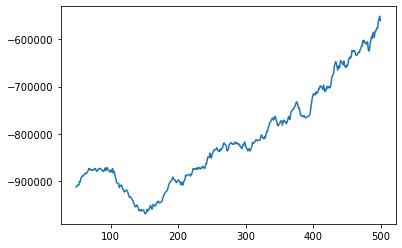

In [308]:
import pandas as pd 

pd.Series(log['mean_reward']).rolling(50).mean().plot()

Some things you may want to consider when writing an agent:

- The action space is combinatorial
- Illegal actions are corrected by the environment
- Observations and rewards are unnormalised by default